Twitter Fingers == Trigger Fingers: A Look at Gun Violence

Data Acquisition and Cleaning Part 1: Data was gathered from one main source, gunviolencearchive.org. Each individual reporting of gun violence comes with sources to prove that it happened, as well as details on the number injured, killed, date, time, and place. The first data acquisition takes these variables, puts them into a dataframe then into csv, as well as finds the source and cleans the links so that they are easily accessible. 

In [19]:
import pandas as pd
import requests
import urllib.request
from bs4 import BeautifulSoup
import re
import numpy as np

Functions

In [20]:
def transform_tables(pd_dataframe):
    # omit the hyperlink column that will be read as NA values
    new_dataframe = pd_dataframe.loc[:,"Incident ID":"# Injured"]
    # rename columns
    new_dataframe = new_dataframe.rename(columns = {"Incident ID": "ID", "Incident Date": "Date", 
                                    "State": "State", "City Or County": "City/County", 
                                    "Address": "Address", "# Killed": "Killed", 
                                    "# Injured": "Injured"})
    return new_dataframe

In [21]:
def save_html(url, path):
    response = requests.get(url)
    with open(path, "wb") as file:
        file.write(response.content)

In [22]:
def get_webpages(soup, year):
    last_webpage_href = soup.find('a', attrs={'title': "Go to last page"})
    last_webpage_path = last_webpage_href.get('href')
    number_of_other_pages = int(re.findall(r'%s(\d+)'%"page=", last_webpage_path)[0])
    if year in range(2014, 2016):
        webpage_paths = ['/reports/mass-shootings/'+ str(year)] # initialize with the first page's path
    else:
        webpage_paths = ['/reports/mass-shooting?year='+ str(year)]
    for page_number in range(1, number_of_other_pages + 1):
        path = re.sub(str(number_of_other_pages), str(page_number), last_webpage_path)
        webpage_paths.append(path)
    return webpage_paths

In [23]:
def get_news_sources(soup):
    news_hrefs = soup.findAll('a', attrs={'href': re.compile("^https://|^http://")})
    news_links = [tag.get('href') for tag in news_hrefs if tag.text == "View Source"] # get all sources listed on a page
    return news_links

In [24]:
def remove_nesting(nested_list):
    return [i for j in nested_list for i in j]

Acquisition and Cleaning

In [25]:
# get all pages paths

web_pages_paths = []
for year in range(2014, 2020):
    path = "mass_shooting_html_"+ str(year)
    soup = BeautifulSoup(open(path,'r'), 'html.parser')
    web_pages_paths.append(get_webpages(soup, year)) # including the first

#web_pages_paths[:2] 


In [26]:
# save first pages html

for year in range(2014, 2020):
    if year in range(2014, 2016):
        first_page_url = "https://www.gunviolencearchive.org/reports/mass-shootings/" + str(year)
    else:
        first_page_url = "https://www.gunviolencearchive.org/reports/mass-shooting?year=" + str(year)
    path = "mass_shooting_html_"+ str(year) 
    save_html(first_page_url, path)
    

In [27]:
sources_container = np.arange(2014, 2020, 1).tolist()
for year_index in range(len(sources_container)):
    year = 2014 + year_index
    sources_container[year_index] = []
    page_index = -1
    for path in web_pages_paths[year_index]:
        page_index += 1
        link = "https://www.gunviolencearchive.org" + path
        filename = "mass_shooting_html_"+ str(year) + "_page_" + str(page_index)
        #save_html(link, filename)
        soup = BeautifulSoup(open(filename,'r'), 'html.parser')
        this_page_sources = get_news_sources(soup)
        sources_container[year_index].append(this_page_sources) 
sources_container[5][8]

['https://www.kmov.com/news/downtown-st-louis-shooting-leaves-injured-overnight/article_5fe78650-a0ba-11e9-afa7-4fca28c07d37.html',
 'https://chicago.suntimes.com/crime/2019/7/7/20684947/4-wounded-englewood-shooting-south-paulina-street-gun-violence',
 'https://chicago.suntimes.com/crime/2019/7/7/20684923/4-wounded-1-critically-englewood-shooting-61st-place',
 'https://www.abqjournal.com/1337222/4-shot-outside-abq-night-club.html',
 'https://www.nbcbayarea.com/news/local/Quadruple-Shooting-San-Jose-Police-512320011.html',
 'https://www.wcvb.com/article/6-people-shot-outside-of-roxbury-party-police-say/28306883',
 'https://www.rgj.com/story/news/2021/03/24/reno-family-says-slayed-teen-hero-third-arrest-made-case/4761896001/',
 'https://chicago.suntimes.com/crime/2019/7/5/20682901/5-wounde-woodlawn-shooting-67th-street-gun-violence',
 'https://abc7ny.com/4-shot-in-brooklyn-after-4th-of-july-fireworks/5379759/',
 'https://www.wifr.com/content/news/Four-people-shot-after-argument-in-Rockfo

In [28]:
news_2014 = remove_nesting(sources_container[0])
news_2015 = remove_nesting(sources_container[1])
news_2016 = remove_nesting(sources_container[2])
news_2017 = remove_nesting(sources_container[3])
news_2018 = remove_nesting(sources_container[4])
news_2019 = remove_nesting(sources_container[5])
news_2019[:5]

['http://www.vermilioncountyfirst.com/2019/12/29/5-women-shot-at-danville-home/',
 'https://www.wkbw.com/news/local-news/4-shot-1-seriously-injured-in-riverside-early-sunday',
 'https://www.modbee.com/news/local/crime/article238828443.html',
 'https://www.modbee.com/news/local/crime/article238841643.html',
 'https://www.11alive.com/article/news/crime/kennesaw-area-shooting-apartment/85-e07c79a0-0881-466e-aa1b-7214148e85e6']

In [29]:
# get the report tables

annual_reports = []
for year in range(2014, 2020):
    first_page_url = "https://www.gunviolencearchive.org/reports/mass-shootings/" + str(year)
    csv_file = str(year) + "_mass_shootings.csv"
    this_year_report = pd.read_csv(csv_file)
    cleaned_report = transform_tables(this_year_report)
    annual_reports.append(cleaned_report)
    

In [30]:
ms_2014 = annual_reports[0]
ms_2015 = annual_reports[1]
ms_2016 = annual_reports[2]
ms_2017 = annual_reports[3]
ms_2018 = annual_reports[4]
ms_2019 = annual_reports[5]

ms_2019[:10]

ID               Date       State       City/County  \
0  1582816  December 29, 2019    Illinois          Danville   
1  1582197  December 29, 2019    New York           Buffalo   
2  1583444  December 29, 2019  California             Ceres   
3  1581590  December 27, 2019  California           Modesto   
4  1581476  December 27, 2019     Georgia          Kennesaw   
5  1581103  December 27, 2019       Texas           Houston   
6  1580308  December 26, 2019     Florida  Saint Petersburg   
7  1579889  December 25, 2019  California           Oakland   
8  1579970  December 25, 2019        Iowa        Coralville   
9  1579856  December 25, 2019    Virginia          Richmond   

                      Address  Killed  Injured  
0  1803 block of Westview Ave       0        5  
1   50 block of Henrietta Ave       1        3  
2   800 block of Allacante Dr       0        5  
3    1900 block of Vernon Ave       1        3  
4       1575 Ridenour Pkwy NW       0        4  
5       500 block of Smart St       2        7  
6               4300 6th St S       0        5  
7      2100 block of 34th Ave       0        4  
8              954 Boston Way       1        3  
9              1800 E Main St       1        3

In [31]:
ms_2014['Source'] = news_2014
ms_2015['Source'] = news_2015
ms_2016['Source'] = news_2016
try:
    ms_2017['Source'] = news_2017
except Exception as e:
    pass
ms_2018['Source'] = news_2018

# ms_2019['Source'] = news_2019 
# gives error since one row does not have a source listed directly

index = news_2019.index("https://www.wcvb.com/article/6-people-shot-outside-of-roxbury-party-police-say/28306883") # index of where it is supposed to be 
news_2019.insert(index, "https://fox2now.com/2019/07/07/north-county-residents-on-edge-after-5-adults-found-dead-in-apartment/")
news_2019 = [news_2019[i] for i in range(len(news_2019)) if news_2019[i] != news_2019[i-1]] 
# in case of re-running the insert code and duplicating

ms_2019['Source'] = news_2019 
ms_2019[:10]


ID               Date       State       City/County  \
0  1582816  December 29, 2019    Illinois          Danville   
1  1582197  December 29, 2019    New York           Buffalo   
2  1583444  December 29, 2019  California             Ceres   
3  1581590  December 27, 2019  California           Modesto   
4  1581476  December 27, 2019     Georgia          Kennesaw   
5  1581103  December 27, 2019       Texas           Houston   
6  1580308  December 26, 2019     Florida  Saint Petersburg   
7  1579889  December 25, 2019  California           Oakland   
8  1579970  December 25, 2019        Iowa        Coralville   
9  1579856  December 25, 2019    Virginia          Richmond   

                      Address  Killed  Injured  \
0  1803 block of Westview Ave       0        5   
1   50 block of Henrietta Ave       1        3   
2   800 block of Allacante Dr       0        5   
3    1900 block of Vernon Ave       1        3   
4       1575 Ridenour Pkwy NW       0        4   
5       500 block of Smart St       2        7   
6               4300 6th St S       0        5   
7      2100 block of 34th Ave       0        4   
8              954 Boston Way       1        3   
9              1800 E Main St       1        3   

                                              Source  
0  http://www.vermilioncountyfirst.com/2019/12/29...  
1  https://www.wkbw.com/news/local-news/4-shot-1-...  
2  https://www.modbee.com/news/local/crime/articl...  
3  https://www.modbee.com/news/local/crime/articl...  
4  https://www.11alive.com/article/news/crime/ken...  
5  https://www.chron.com/news/houston-texas/houst...  
6  https://www.tampabay.com/news/st-petersburg/20...  
7  https://abc7news.com/quadruple-shooting-at-hol...  
8  https://www.kcrg.com/2020/07/08/brothers-now-j...  
9   https://wtvr.com/2019/12/25/kenneth-lawson-obit/

In [32]:
ms_2014.to_csv(path_or_buf = "complete_2014_dataset")
ms_2015.to_csv(path_or_buf = "complete_2015_dataset")
ms_2016.to_csv(path_or_buf = "complete_2016_dataset")
ms_2017.to_csv(path_or_buf = "complete_2017_dataset")
ms_2018.to_csv(path_or_buf = "complete_2018_dataset")
ms_2019.to_csv(path_or_buf = "complete_2019_dataset") # export as csv files

In [33]:
merged_data = pd.concat([ms_2014, ms_2015, ms_2016, ms_2017, ms_2018, ms_2019])
print(len(merged_data))
merged_data.to_csv(path_or_buf = "complete_project_dataset1")

2085


Data Acquisition Part 2: The second step of the data acquisition process was to access the sources, and find the article text from each source. This allows us to create a second set of data in a text file for analysis of all words from these articles, "articletext". 

In [34]:
import pandas as pd
from bs4 import BeautifulSoup
import socket
import urllib.request

#reads in complete project data
gunviolencedataset = pd.read_csv("complete_project_dataset")
sourceurl = gunviolencedataset["Source"] #creates a series of just the source urls

The function that takes the source url, goes to the url, reads in the text from that site. The function then writes the text from the "p" tag to a text file, so that it can be accessed afterwards. 

In [36]:
def getsourcetext(urlseries):
    #initialize beautifulsoup
    soup = BeautifulSoup('''<html>  </html>''', 'html.parser') 
    timeout = 20 #creates a timeout variable w an int
    socket.setdefaulttimeout(timeout) #uses timeout to set the socket timeout
    textfile = open("articletext1", "w+",  encoding="utf-8") #creates a writing file
    for k in urlseries: #runs this loop for every entry in the series
        try:
            html = urllib.request.urlopen(url=k) #opens k website
            html = html.read() #reads in website info
            htmlfile = html.decode('utf-8') #decodes the info into a new file
        #need to make exceptions for 404/403/etc
        except Exception as e:
            continue
        else: #what to do after try block works or doesn't work
            singlesoup = BeautifulSoup(htmlfile, 'html.parser') #the variable that holds the data from the article
            for n in singlesoup("p"): #finds p tag (the main paragraph of the article)
                textfile.write(n.get_text(strip=True)) #we only want the parts of the article that are from the main paragraph
            soup.append(singlesoup) #adds the html file to the collective beautiful soup file
    textfile.close()
    return soup

The below block gives the "allhtmlfiletext" file and creates a beautifulsoup object of all the htmlfiles in the series. The purpose of creating the "allhtmlfiletext" is so that the getsourcetext() function defined above doesn't have to run everytime, it takes about 40-50 minutes to complete. 

In [37]:
sourcesoup = getsourcetext(sourceurl) #makes sourcesoup into the entire beautiful soup, as well as finds the links of the source url series
allhtmlfiles = sourcesoup.get_text(strip=True) #gets all of the written words out as a sting
allhtmltxt = open("allhtmlfiletext", "w", encoding = "utf-8") #creates a file
allhtmltxt.write(allhtmlfiles) #adds this string to the file
allhtmltxt.close() #closes file

Exploratory Analysis: After obtaining and cleaning the data, we wanted to look at the statistics and visualization of the data gathered. 

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import datetime
import matplotlib
import matplotlib.pyplot as plt
import statistics

In [2]:
data = pd.read_csv('complete_project_dataset',index_col=0)

data_2014 = data[0:269]
data_2015 = data[270:604]
data_2016 = data[605:986]
data_2017 = data[987:1332]
data_2018 = data[1333:1668]
data_2019 = data[1669:2085]

data_2017

ID               Date        State   City/County  \
1    1017422  December 31, 2017     Illinois       Chicago   
2    1018118  December 31, 2017   New Jersey   Long Branch   
3    1015666  December 27, 2017       Nevada     Las Vegas   
4    1015336  December 26, 2017      Florida         Miami   
5    1013983  December 24, 2017  Mississippi     Vicksburg   
..       ...                ...          ...           ...   
341   742542    January 4, 2017   California       Fontana   
342   742001    January 3, 2017        Texas         Allen   
343   743282    January 1, 2017  Mississippi  Winstonville   
344   739451    January 1, 2017        Texas        Dallas   
345   739766    January 1, 2017      Florida         Miami   

                          Address  Killed  Injured  \
1                  2335 Howard St       0        4   
2                     635 Wall St       4        0   
3               3750 E Bonanza Rd       2        2   
4        NW 18th Ave and 86th Ter       0        5   
5            1111 Mulberry Street       0        5   
..                            ...     ...      ...   
341           14520 Village Drive       3        1   
342  500 block of Hawthorne Drive       0        4   
343       114 North Greyer Street       0        5   
344          9220 Skillman Street       1        3   
345     8000 block of NW 14th Ave       0        7   

                                                Source  
1    https://chicago.suntimes.com/news/3-wounded-1-...  
2    http://www.nj.com/monmouth/index.ssf/2018/01/t...  
3    https://lasvegassun.com/news/2017/dec/28/calif...  
4    http://wsvn.com/news/local/5-hospitalized-afte...  
5    http://deltadailynews.com/downtown-vicksburg-s...  
..                                                 ...  
341  http://www.fresnobee.com/news/local/crime/arti...  
342  http://www.star-telegram.com/news/local/crime/...  
343  http://www.bolivarcommercial.com/newsx/item/54...  
344  http://www.wfaa.com/news/local/second-death-by...  
345  http://wsvn.com/news/local/7-injured-in-nw-mia...  

[345 rows x 8 columns]

In [3]:
dates = []
num_killed = []
num_injured = []

for row in range(len(data)):
    x = datetime.datetime.strptime(data.iloc[row,1],"%B %d, %Y")
    if x in dates:
        num_killed[len(num_killed)-1]+= data.iloc[row,5]
        num_injured[len(num_injured)-1]+= data.iloc[row,6]
    else:
        dates.append(x)
        num_killed.append(data.iloc[row,5])
        num_injured.append(data.iloc[row,6])
        

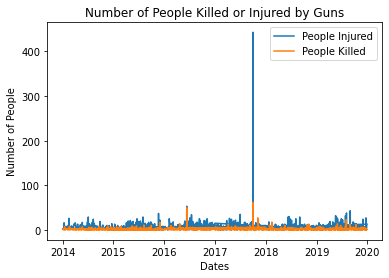

In [4]:
plt.plot(dates, num_injured, label = "People Injured")
plt.plot(dates, num_killed, label = "People Killed")

# naming the x axis
plt.xlabel('Dates')
# naming the y axis
plt.ylabel('Number of People')
# giving a title to my graph
plt.title('Number of People Killed or Injured by Guns')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

In [5]:
d = {'statistic' : ['mean','median','mode','std','min','max'], 
     'Number Killed' : [np.mean(num_killed),np.median(num_killed),statistics.mode(num_killed),np.std(num_killed),min(num_killed),max(num_killed)],
    'Number Injured' : [np.mean(num_injured),np.median(num_injured),statistics.mode(num_injured),np.std(num_injured),min(num_injured),max(num_injured)]
    }

stats_of_the_data = pd.DataFrame(data = d)
print(stats_of_the_data)

  statistic  Number Killed  Number Injured
0      mean       1.952736        7.290216
1    median       1.000000        5.000000
2      mode       0.000000        4.000000
3       std       3.285768       13.786708
4       min       0.000000        0.000000
5       max      62.000000      443.000000


Analaysis Method Outlines: NLP and Sentiment Analysis Classification

NLP Analysis: We wanted to use Natural Language Processing to inspect the relations of words in the articles we find, in the hopes that we can relate fequency of word use and the context that these fequently used words are in to the increase of gun violence in America. To start this the article text extracted must be tokenized (sorted into words), remove the words and punctuation that are too common to be useful, and assess the frequency of the cleaned words. Then ngrams are created of these words to assess the context that the frequent words come in. 

What remains to be done is connect these results to collective meaning about the articles, and how that relates to gun violence. 

In [6]:
import nltk
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

articletextfile = open("articletext", encoding='utf-8')
articlestring = articletextfile.read()
articletextfile.close()

#need to tokenize the article text
tokenizer = RegexpTokenizer(r'\w+')
articletext = tokenizer.tokenize(articlestring)

#need to remove stopwords and punctuation
stopwords = nltk.corpus.stopwords.words('english')
capstopwords = [w.title() for w in stopwords]
numbers = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "zero"]
stopwords.extend(capstopwords)
stopwords.extend(numbers)
articletext = [word.lower() for word in articletext if word not in stopwords]

#finds most common words
frequency_dist = FreqDist(articletext)
keywordstuple = frequency_dist.most_common(10)
keywords = []
for wordtuple in keywordstuple:
    keywords.append(wordtuple[0])
print(keywordstuple)

[('said', 7104), ('police', 6228), ('shooting', 4410), ('shot', 3082), ('year', 2999), ('people', 2895), ('old', 2724), ('man', 2187), ('victims', 1512), ('according', 1478)]


In [7]:
#ngram analysis of text
bigrams = nltk.bigrams(articletext)
trigrams = nltk.trigrams(articletext)
bigramlist = list(bigrams)
trigramlist = list(trigrams)
#need to find the keywords in the ngrams
keywordbigrams = [word_tuple for word_tuple in bigramlist if ((word_tuple[0] in keywords) | (word_tuple[1] in keywords))]
keywordtrigrams = [word_tuple for word_tuple in trigramlist if ((word_tuple[0] in keywords) | (word_tuple[1] in keywords) | (word_tuple[2] in keywords))]
#

Sentiment Analysis: Our second kind of analysis for the article is going to be sentiment analysis classification. We created a classification model that trains on a library of tweets that are rated from 0 through 4 on a negative-positive scale. The tweet is vectorized into features and its rating. 

In [41]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
try:
    from gensim.models import Word2Vec
except Exception as e:
    pass
from collections import Counter

import nltk
#nltk.download('all')

Importing and trimming twitter sentiment dataset

Insert header, remove numbers, usernames, and NO_QUERY

Move first row that became header down to data, add headers

In [42]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = "ISO-8859-1",names=["score","id","datetime","NO_QUERY","usernames","tweet"])

df = df.drop(['id','NO_QUERY','usernames'],axis=1)

df.head()

score                      datetime  \
0      0  Mon Apr 06 22:19:45 PDT 2009   
1      0  Mon Apr 06 22:19:49 PDT 2009   
2      0  Mon Apr 06 22:19:53 PDT 2009   
3      0  Mon Apr 06 22:19:57 PDT 2009   
4      0  Mon Apr 06 22:19:57 PDT 2009   

                                               tweet  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

Checking count values, dataset listed from 0 = negative to 4 = positive. 

In [63]:
df = df.iloc[0:20000, :]
print(df.shape)
print(df['score'].value_counts())

(20000, 3)
neg    20000
Name: score, dtype: int64


Clean up links, @users, hastags

In [64]:
stopwords = nltk.corpus.stopwords.words("english")

def cleanup(text):
    clean = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",str(text)).split()
    tokens = []
    for token in clean:
        if token not in stopwords:
            tokens.append(token)
    return tokens

In [65]:
df['tweet'] = df['tweet'].apply(lambda x: cleanup(x))

df['score'] = df['score'].replace([0,4],['neg','pos'])

df.head()

score                      datetime  \
0   neg  Mon Apr 06 22:19:45 PDT 2009   
1   neg  Mon Apr 06 22:19:49 PDT 2009   
2   neg  Mon Apr 06 22:19:53 PDT 2009   
3   neg  Mon Apr 06 22:19:57 PDT 2009   
4   neg  Mon Apr 06 22:19:57 PDT 2009   

                                               tweet  
0  [Awww, bummer, You, shoulda, got, David, Carr,...  
1  [upset, update, Facebook, texting, might, cry,...  
2  [I, dived, many, times, ball, Managed, save, 5...  
3            [whole, body, feels, itchy, like, fire]  
4                            [behaving, mad, I, see]

In [66]:
def to_tuple(x):
    subset = x[['tweet','score']]
    tuples = [tuple(i) for i in subset.to_numpy()]
    return tuples

In [67]:
documents = to_tuple(df)
documents[0]

(['Awww',
  'bummer',
  'You',
  'shoulda',
  'got',
  'David',
  'Carr',
  'Third',
  'Day',
  'D'],
 'neg')

In [68]:
def word_master(x):
    master_list = []
    for i in range(len(x)):
        master_list += x['tweet'][i]
    return master_list

words = word_master(df)

In [69]:
def word_master(x):
    master_list = []
    for i in range(len(x)):
        master_list += x['tweet'][i]
    return master_list

words = word_master(df)

word_features = nltk.FreqDist(w.lower() for w in words).most_common(2000)
word_features =  [word_tuple[0] for word_tuple in word_features]
word_features[0:5]

['i', 'work', 'go', 'get', 'day']

In [70]:
def document_features(document):    
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains('+ word +')'] = (word in document_words)
    return features

featuresets = [(document_features(d), c) for (d,c) in documents]

The words as feature vectors have been computed, this then establishes the training and test sets. Then runs the classification model on the test set. 

What remains to be done here is test the model on the article data which also needs to be turned into feature vectors. 

In [71]:
train_set, test_set = featuresets[100:], featuresets[:100]
classifier = nltk.NaiveBayesClassifier.train(train_set)

print(nltk.classify.accuracy(classifier, test_set))

classifier.show_most_informative_features(10)

1.0
Most Informative Features
